In [ ]:
# default_exp ml

# Ml

In [13]:
# hide
from nbdev.showdoc import *
from fastcore.nb_imports import *
from fastcore.test import *

import warnings
warnings.filterwarnings('ignore')

In [19]:
# export
import pandas as pd

from scipy import stats
import numpy as np
from tqdm.notebook import trange

def build_timeseries(df, features, timeslice_length, window_step_size=1, ignore_label='not_defined'):
    "Split the data in `df` into timeseries segments of length `timeslice_length` containing given `features`."
    
    segments = []
    labels = []
    for i in trange(0, len(df) - timeslice_length + 1, window_step_size):
        s = []
        i_end = i + timeslice_length
        for f in features:
            s.append(df[f[0], f[1]].values[i:i_end])
            
        # identify label
        dominant_label = stats.mode(df['behavior'][i:i_end])[0][0]
        
        if dominant_label != ignore_label:
            segments.append(s)
            labels.append(dominant_label)
    
    orderd_labels = sorted(list(set(labels))) # pd.get_dummies orders alphabetically, needed for decoding
    df_encoded_labels = pd.get_dummies(labels)
    label_vector = np.asarray(df_encoded_labels, dtype = np.float32)
    
    return np.asarray(segments).reshape(-1, timeslice_length, len(features)), label_vector, orderd_labels

Let's assume you have some data that has been labelled using the `label_assistant` module. For the sake of this example, we will just use some dummy data and set some dummy labels manually.

In [15]:
df = pd.read_hdf('example_classified_data/labelled_behaviors.h5')
df.iloc[22:38].loc[:, ['behavior']] = 'foobar'
df.iloc[81:99].loc[:, ['behavior']] = 'baz'
df

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
0          773.376465  231.518768   0.999999  726.495178  235.638046   
1          773.129822  231.487213   0.999999  725.662231  235.242844   
2          773.009827  231.793518   0.999999  726.025696  235.272522   
3          773.748779  231.791260   0.999999  726.288940  235.864319   
4          774.934326  231.623734   0.999999  726.298279  235.749908   
..                ...         ...        ...         ...         ...   
95         691.788513  232.490265   1.000000  673.796082  238.801743   
96         691.545410  232.707413   1.000000  673.634888  238.658234   
97         691.117371  232.242767   1.000000  673.748840  239.055954   
98         691.294067  232.225220   1.000000  673.927002  239.141891   
99         691.483643  232.269226   1.000000  673.797241  239.390625   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999981  726.502014  277.634125   0.999998  803.271179  ...   
1           0.999951  725.964478  278.003082   0.999999  803.197144  ...   
2           0.999978  725.764893  278.884918   0.999998  802.567810  ...   
3           0.999985  725.889465  279.045715   0.999998  803.356934  ...   
4           0.999990  726.302551  278.388367   0.999999  802.530273  ...   
..               ...         ...         ...        ...         ...  ...   
95          0.018886  697.399841  282.134796   0.999998  737.725342  ...   
96          0.016135  697.256165  283.058899   0.999999  736.505920  ...   
97          0.007289  696.269043  282.351929   0.999999  735.976685  ...   
98          0.004682  695.629456  282.407013   1.000000  735.639404  ...   
99          0.010126  695.367371  281.720947   0.999999  735.199585  ...   

bodyparts right_down_wing        body                               tail  \
coords         likelihood           x           y likelihood           x   
0                0.999997  804.008545  350.669586   0.999992  874.878601   
1                0.999989  802.684265  345.021454   0.999873  875.375854   
2                0.999995  801.531067  349.937347   0.999946  876.269714   
3                0.999994  802.792908  350.675842   0.999970  875.973022   
4                0.999998  803.659973  351.269745   0.999938  876.481873   
..                    ...         ...         ...        ...         ...   
95               0.999980  788.017456  337.912994   0.999999  882.997253   
96               0.999943  788.334045  339.911743   0.999999  884.470215   
97               0.999916  785.626465  338.561829   0.999997  885.270691   
98               0.999876  786.011963  338.520691   0.999997  885.585388   
99               0.999786  785.282776  338.077087   0.999992  885.361023   

bodyparts                               file_name frame     behavior  
coords              y likelihood                                      
0          485.749908   0.999999   coordinates.h5     0  not_defined  
1          487.185547   0.999997   coordinates.h5     1  not_defined  
2          485.816010   0.999999   coordinates.h5     2      pecking  
3          485.560150   0.999998   coordinates.h5     3      pecking  
4          485.140839   0.999998   coordinates.h5     4      pecking  
..                ...        ...              ...   ...          ...  
95         483.786896   1.000000  coordinates2.h5    95  not_defined  
96         483.485382   1.000000  coordinates2.h5    96  not_defined  
97         485.053131   0.999999  coordinates2.h5    97  not_defined  
98         484.755859   0.999999  coordinates2.h5    98  not_defined  
99         483.480896   1.000000  coordinates2.h5    99  not_defined  

[200 rows x 39 columns]

The `build_timeseries` function can be used to prepare the data for Keras. By defining the `window_step_size` it is possible to model a sliding (default, `step_size = 1`), hopping (`1 < step_size < timeslice_length`), or a tumbling (`step size < timeslice_length`) window.

In [24]:
features = [('head', 'x'), ('head', 'y'), ('tail', 'x')]
timeslice_length = 20
segmented_timeseries, label_vector, label_names = build_timeseries(df, features, timeslice_length, window_step_size=timeslice_length)

result_shape = segmented_timeseries.shape
test_eq(result_shape[0], 2)
test_eq(result_shape[1], timeslice_length)
test_eq(result_shape[2], 3)
test_eq(label_names, ['baz', 'foobar'])

  0%|          | 0/10 [00:00<?, ?it/s]

As an alternative, we can build segments using a sliding window (which is used as the default).

In [21]:
features = [('head', 'x'), ('head', 'y'), ('tail', 'x')]
timeslice_length = 7
sliding_segmented_timeseries, sliding_label_vector, sliding_label_names = build_timeseries(df, features, timeslice_length)

result_shape = sliding_segmented_timeseries.shape
test_eq(result_shape[0], 43)
test_eq(result_shape[1], timeslice_length)
test_eq(result_shape[2], 3)

# segments that are indentified as `not_defined` are not included
test_eq(sliding_label_names, ['baz', 'foobar', 'pecking', 'shaking'])

  0%|          | 0/194 [00:00<?, ?it/s]

Once the data has the correct shape, we can leverage other libraries such as `sklearn` to split the data into a training and test set.

In [ ]:
from sklearn.model_selection import train_test_split

""" 
splitting data into training and test data 
-> test_size=0.4 results in 60% for training and 40% for testing
-> shuffle the data by default true
"""
x_train, x_test, y_train, y_test = train_test_split(
        segmented_timeseries, label_vector, test_size=0.4)

In [ ]:
# export
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    # If `set_memory_growth` is not set, we observed crashes through `CUBLAS_STATUS_ALLOC_FAILED` and similar errors. 
    # While we are not really sure why the default settings lead to this problem, the pragmatic approach like 
    # this seems to work and is also discussed on SO: 
    # https://stackoverflow.com/questions/41117740/tensorflow-crashes-with-cublas-status-alloc-failed
    tf.config.experimental.set_memory_growth(gpus[0], True)

def build_model(train_input, train_output, lr=0.0015):
    """Compile a tensorflow model for the given input and output shapes."""
    net_in = Input(shape=(train_input.shape[1:]))
    x = Conv1D(filters=64, kernel_size=2, padding="valid")(net_in)  
    x = Activation("relu")(x)                                       
    x = BatchNormalization()(x)                                     
    x = Conv1D(filters=128, kernel_size=3, padding="valid")(x)       
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = Conv1D(filters=16, kernel_size=4, padding="valid")(x)
    x = Activation("relu")(x)
    x = BatchNormalization()(x)
    x = GlobalMaxPooling1D()(x)
    x = Flatten()(x)
    x = Dense(128)(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.3)(x) # freezes 30% of connections to the next layer (to prevent overfitting)
    x = Dense(64)(x)
    x = Activation("relu")(x)
    x = Dropout(rate=0.3)(x)
    x = Dense(train_output.shape[1])(x)
    output = Activation("softmax")(x)

    cnn = Model(inputs=net_in, outputs=output)
    cnn.compile(loss="categorical_crossentropy", optimizer=Adam(lr=lr), metrics=["categorical_accuracy"])
    return cnn

def build_lstm_model(train_input, train_output):
    net_in = train_input.shape[1:]
    out = len(train_output[0])
    print("Output neurons: " + str(out))
    
    model = Sequential()
    model.add(LSTM(120, input_shape=net_in, return_sequences=True,  dropout=0.2))
    model.add(LSTM(120, input_shape=net_in, return_sequences=True,  dropout=0.2)) # added
    #model.add(LSTM(100, input_shape=input_dim, return_sequences=True,  dropout=0.2)) # added#############################################
    model.add(LSTM(100, dropout=0.2))
    model.add(Dense(100, activation="relu"))
    #model.add(Dense(80, activation="relu")) # added#########################################################
    model.add(Dense(64, activation="relu"))
    model.add(Dense(out, activation="softmax"))
    
    opt = Adam(lr=0.0002, clipvalue=0.5) # lr=0.0001
    model.compile(loss='categorical_crossentropy', optimizer = opt, metrics=['categorical_accuracy'])
    
    return model
    

The `build_model` function can be used to build a tensorflow model that fits the given input data and the expected classification outputs.

In [ ]:
model = build_model(x_train, label_vector)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 20, 3)]           0         
_________________________________________________________________
conv1d (Conv1D)              (None, 19, 64)            448       
_________________________________________________________________
activation (Activation)      (None, 19, 64)            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 19, 64)            256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 17, 128)           24704     
_________________________________________________________________
activation_1 (Activation)    (None, 17, 128)           0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 17, 128)           512   

In [ ]:
lstm = build_lstm_model(segmented_timeseries, label_vector)
lstm.summary()

Output neurons: 3
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 20, 120)           59520     
_________________________________________________________________
lstm_1 (LSTM)                (None, 20, 120)           115680    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               88400     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 64)                6464      
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 195       
Total params: 280,359
Trainable params: 280,359
Non-trainable params: 0
________________________________

# Using TensorFlow

From now on, we can fallback to the existing TensorFlow API. For the sake of documentation, the further processing is given as an example.

In [ ]:
hist = model.fit(x_train,
        y_train,
        batch_size=32,
        epochs=100)

hist_lstm = model.fit(x_train,
        y_train,
        batch_size=32,
        epochs=100)

Epoch 1/100
1/1 [==============================] - 5s 5s/step - loss: 3.2760 - categorical_accuracy: 0.0000e+00
Epoch 2/100
1/1 [==============================] - 0s 13ms/step - loss: 1.7259 - categorical_accuracy: 0.3333
Epoch 3/100
1/1 [==============================] - 0s 11ms/step - loss: 1.0009 - categorical_accuracy: 0.1667
Epoch 4/100
1/1 [==============================] - 0s 14ms/step - loss: 0.7014 - categorical_accuracy: 0.8333
Epoch 5/100
1/1 [==============================] - 0s 14ms/step - loss: 0.5841 - categorical_accuracy: 0.8333
Epoch 6/100
1/1 [==============================] - 0s 16ms/step - loss: 0.9946 - categorical_accuracy: 0.8333
Epoch 7/100
1/1 [==============================] - 0s 12ms/step - loss: 0.6048 - categorical_accuracy: 0.8333
Epoch 8/100
1/1 [==============================] - 0s 13ms/step - loss: 0.5492 - categorical_accuracy: 0.6667
Epoch 9/100
1/1 [==============================] - 0s 15ms/step - loss: 0.5005 - categorical_accuracy: 0.6667
Epoch 10

In [ ]:
hist.history

{'loss': [3.276013135910034,
  1.7258610725402832,
  1.000933051109314,
  0.7014167904853821,
  0.584064781665802,
  0.9946103692054749,
  0.6047560572624207,
  0.5492415428161621,
  0.5005459785461426,
  0.41250428557395935,
  0.31805089116096497,
  0.41973844170570374,
  0.7505106925964355,
  0.5802701115608215,
  0.6018146872520447,
  0.31452471017837524,
  0.5877074003219604,
  0.6086848378181458,
  0.44349566102027893,
  0.8248381614685059,
  0.40612030029296875,
  0.7123731970787048,
  0.44825538992881775,
  0.6463466286659241,
  0.42591527104377747,
  0.4296729266643524,
  0.4118047058582306,
  0.3417684733867645,
  0.5555299520492554,
  0.4457618296146393,
  0.34349480271339417,
  0.5154827237129211,
  0.4824921190738678,
  0.4520540237426758,
  0.3684549629688263,
  0.4828759431838989,
  0.5844061970710754,
  0.38276544213294983,
  0.6842062473297119,
  0.4247576892375946,
  0.4015878736972809,
  0.523617684841156,
  0.38118886947631836,
  0.45263949036598206,
  0.591498017311

The training progress over time can be visualized using `matplotlib`.

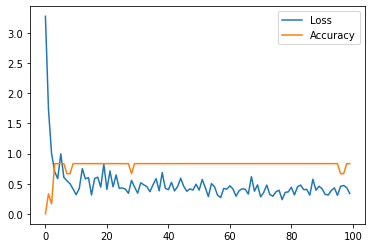

In [ ]:
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'], label="Loss")
plt.plot(hist.history['categorical_accuracy'], label="Accuracy")
plt.legend()
plt.show()

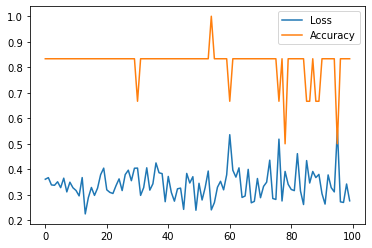

In [ ]:
plt.plot(hist_lstm.history['loss'], label="Loss")
plt.plot(hist_lstm.history['categorical_accuracy'], label="Accuracy")
plt.legend()
plt.show()

By using the test set, the accuary of the trained model can be assessed.

In [ ]:
results = model.evaluate(x_test, y_test, batch_size=32)
print("test loss: ", results[0], "\ttest accuracy: ", results[1])

1/1 [==============================] - 0s 212ms/step - loss: 2.4919 - categorical_accuracy: 0.7500
test loss:  2.4918806552886963 	test accuracy:  0.75


A useful way to visualize the accuary is using a confusion matrix.

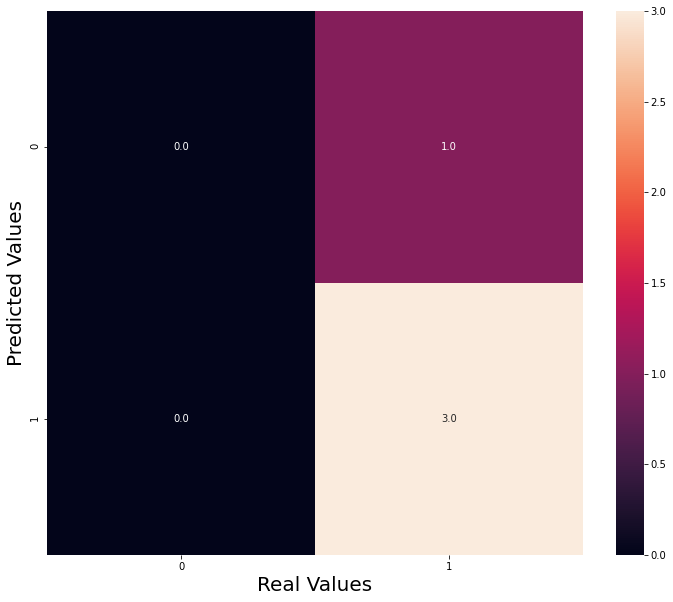

In [ ]:
# getting predicted values for test data
y_pred = model.predict(x_test)

from sklearn.metrics import confusion_matrix

# matching true labels to predicted output
y_true=np.argmax(y_test, axis=1)
confusion = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

df_cm = pd.DataFrame(confusion)
plt.figure(figsize = (12,10))

import seaborn as sn
ax = sn.heatmap(df_cm, annot=True, fmt=".1f")
plt.xlabel("Real Values", fontsize=20)
plt.ylabel("Predicted Values", fontsize=20)

plt.show()